# BDL CW1 - Christopher McGahon 

In [22]:
#Auth so we can run commands
#Set up of any libs used throughout the code
import pandas as pd 
import numpy as np
import folium
from pandas import read_csv
import plotly.express as px
import matplotlib.pyplot as plt
from google.cloud import storage
from pandas.io import gbq
import os
from io import StringIO 
from tensorflow.python.lib.io import file_io
%matplotlib inline
plt.style.use('default')

In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
#Put all from the dataset to a dataframe 
%%bigquery --project strategic-howl-293309 alldata 
SELECT * FROM `bigquery-public-data.covid19_govt_response.oxford_policy_tracker`

In [4]:
#Put question1 from the dataset to a dataframe 
%%bigquery --project strategic-howl-293309 question1 
SELECT * FROM `strategic-howl-293309.BDL_CW1.question1`

In [106]:
#Put question2 from the dataset to a dataframe 
%%bigquery --project strategic-howl-293309 question2 
SELECT * FROM `strategic-howl-293309.BDL_CW1.question2` WHERE Growth_percent < 10 AND Growth_percent > 0

In [10]:
#Put usadata from the dataset to a dataframe 
%%bigquery --project strategic-howl-293309 usadata 
SELECT * FROM `strategic-howl-293309.BDL_CW1.usadata`

# Question 1

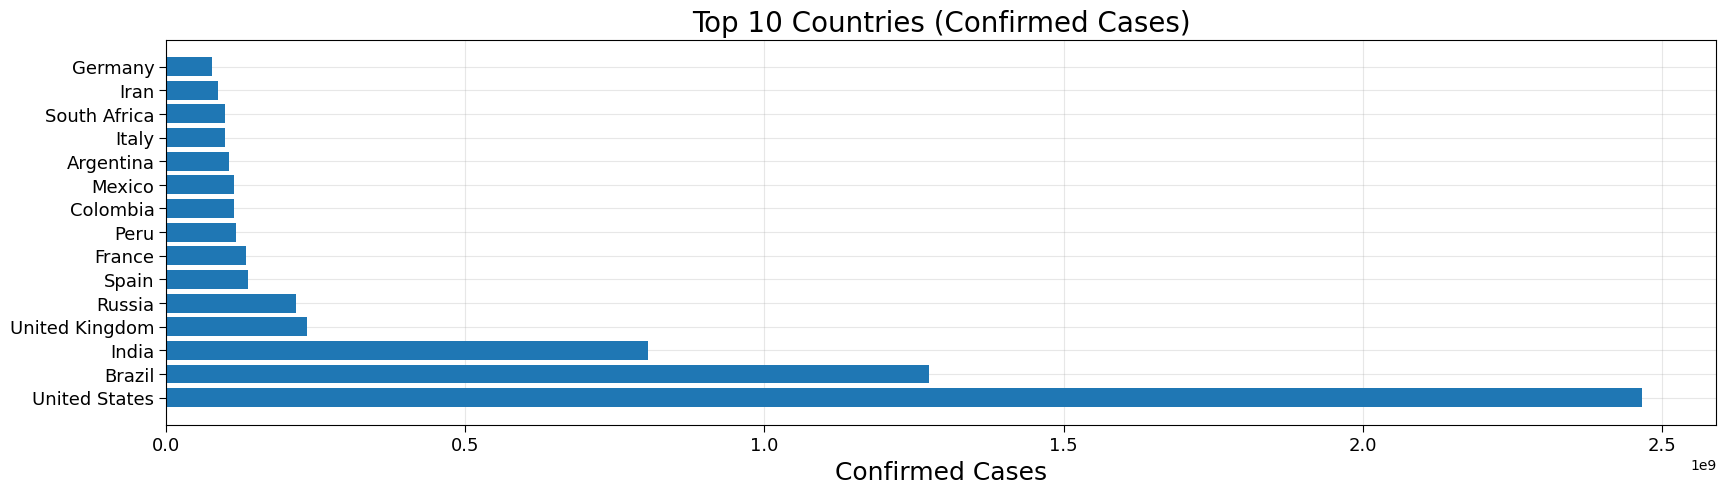

In [6]:
f = plt.figure(figsize=(20,5))
f.add_subplot(111)
plt.axes(axisbelow=True)
plt.barh(question1.country_name, question1.cases_count)   
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3) 

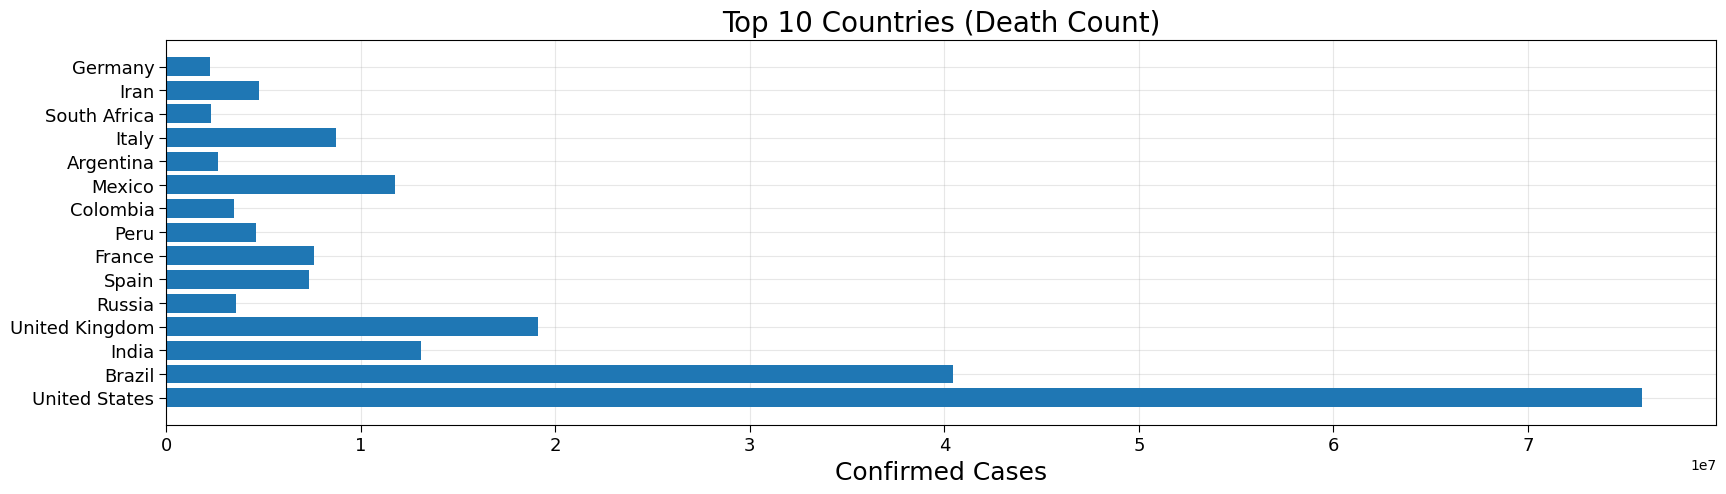

In [7]:
f = plt.figure(figsize=(20,5))
f.add_subplot(111)
plt.axes(axisbelow=True)
plt.barh(question1.country_name, question1.death_count)   
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (Death Count)",fontsize=20)
plt.grid(alpha=0.3) 

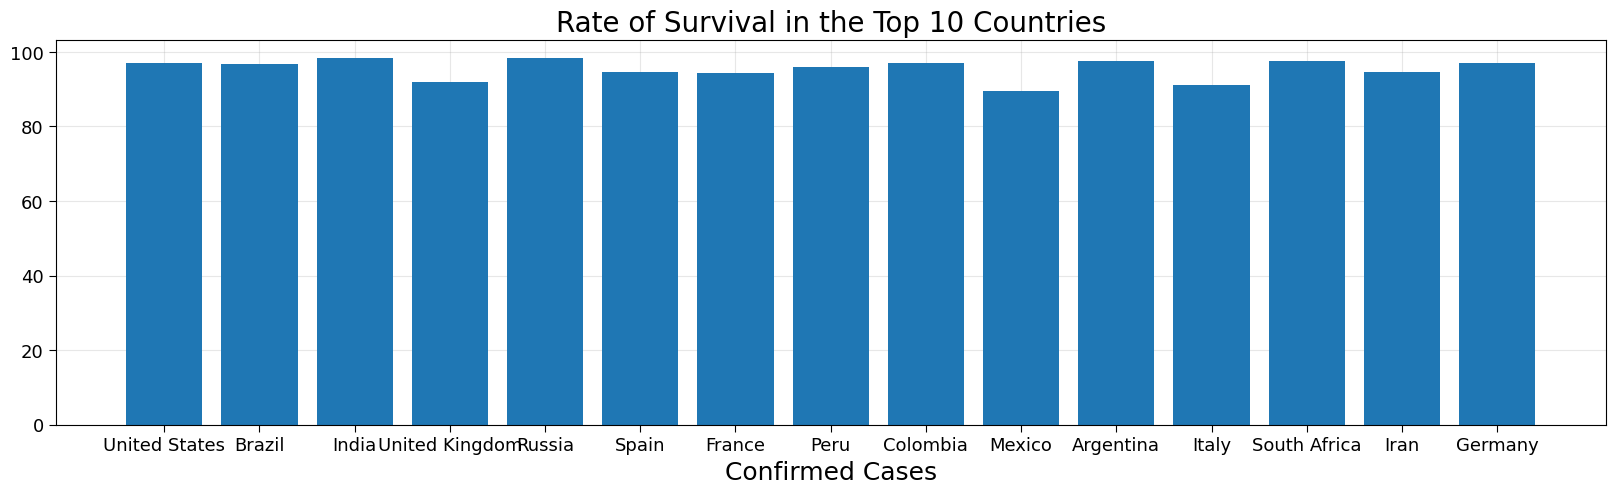

In [8]:
f = plt.figure(figsize=(20,5))
f.add_subplot(111)
plt.axes(axisbelow=True)
plt.bar(question1.country_name, question1.Survival_Rate)   
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Rate of Survival in the Top 10 Countries",fontsize=20)
plt.grid(alpha=0.3) 

In [ ]:
fig = px.choropleth(question1, locations="country_name",
                    color=np.log10(question1["cases_count"]), # lifeExp is a column of gapminder
                    hover_name="cases_count", # column to add to hover information
                    hover_data=["cases_count"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_layout(title_text="Confirmed Cases Heat Map")
fig.update_coloraxes(colorbar_title="Confirmed Cases",colorscale="Reds")
fig.show(renderer='colab')

In [11]:
usadata["usa_cases"] = np.log10(usadata["usa_cases"]+1)
bins = list(usadata['usa_cases'].quantile([0, 0.25, 0.5, 0.75,0.95 ,1]))
m = folium.Map(location=[37, -102], zoom_start=4,max_zoom=6,min_zoom=3)
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
# Add the color for the chloropleth:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data = usadata,
    columns=['region_name', 'usa_cases'],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins = bins,
    reset=True,
    legend_name='Confirmed cases log ('
).add_to(m)
folium.LayerControl().add_to(m)
m

# Question 2

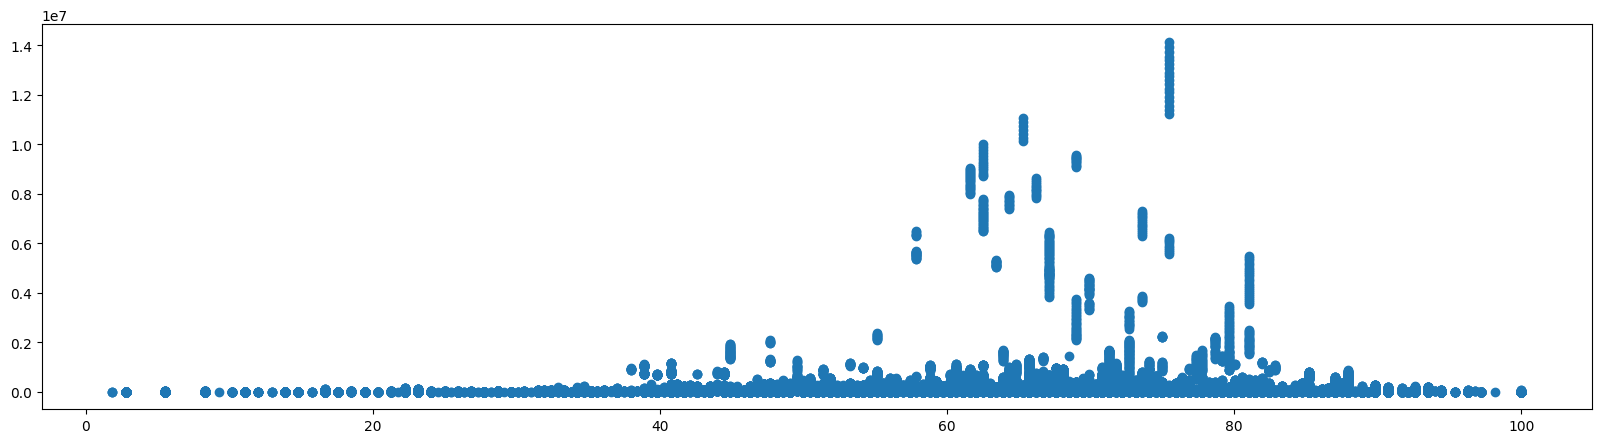

In [12]:
x = question2.stringency_index
y = question2.confirmed_cases
f = plt.figure(figsize=(20,5))
plt.scatter(x, y, marker='o');

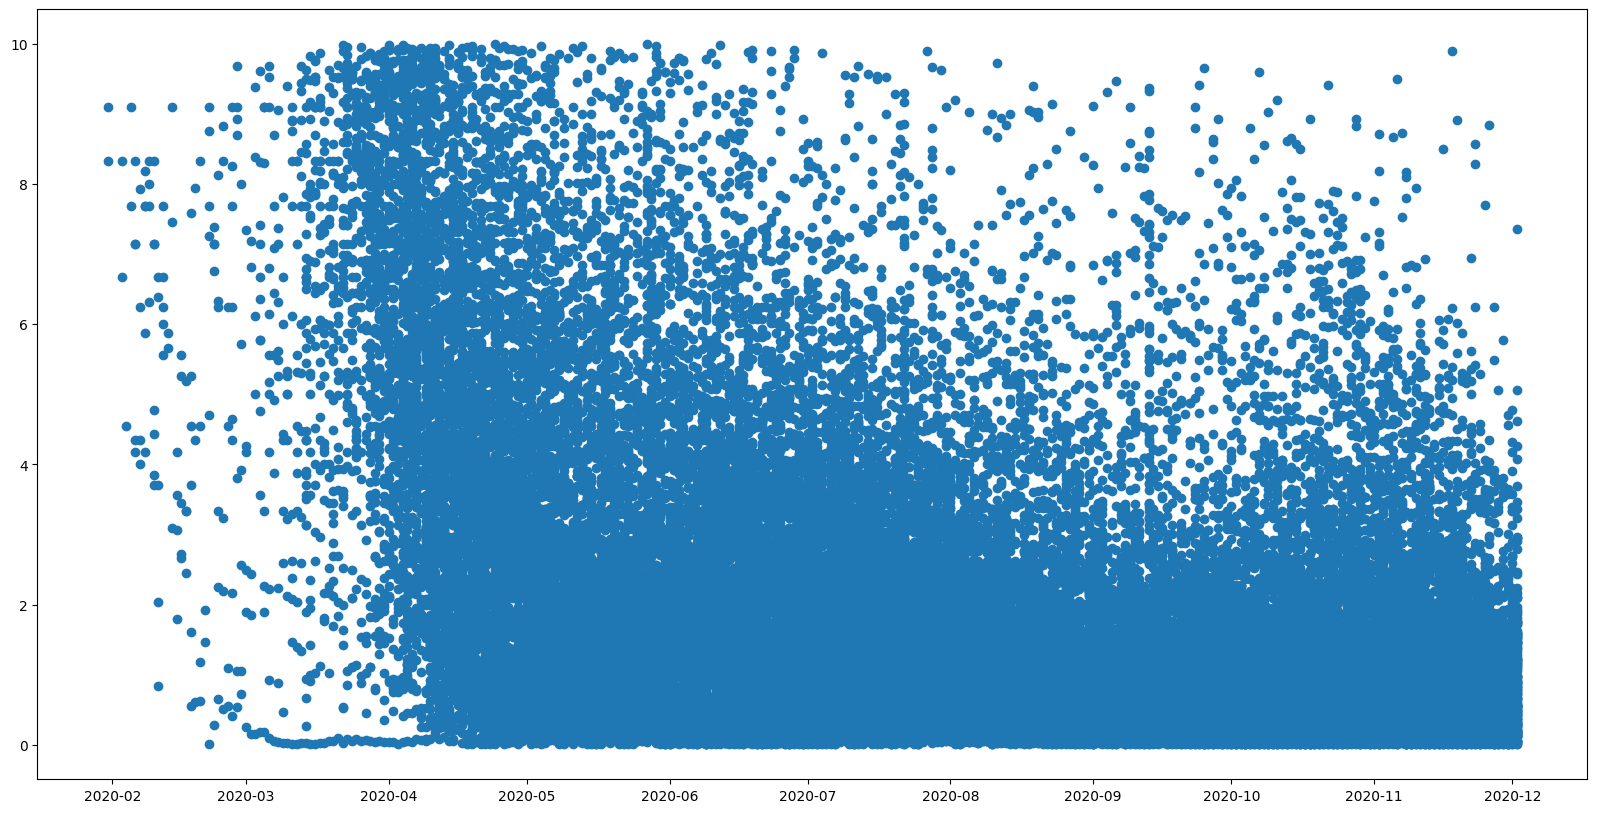

In [108]:
x = question2.date
y = question2.Growth_percent
f = plt.figure(figsize=(20,10))
plt.scatter(x, y, marker='o');

# Task 3

In [14]:
project_id = 'strategic-howl-293309'
!gcloud config set project {project_id}
os.environ["GCLOUD_PROJECT"] = project_id

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [15]:
bucket_name = 'bdl-cw1-s2102466-chrismcgahon'
!gsutil mb gs://{bucket_name}

Creating gs://bdl-cw1-s2102466-chrismcgahon/...
ServiceException: 409 Bucket bdl-cw1-s2102466-chrismcgahon already exists.


In [16]:
gcs = storage.Client()
f = StringIO()
question1.to_csv(f)
f.seek(0)
gcs.bucket(bucket_name).blob('question1.csv').upload_from_file(f, content_type='text/csv')

In [17]:
print('\nList of files in bucket')
!gsutil ls gs://{bucket_name}


List of files in bucket
gs://bdl-cw1-s2102466-chrismcgahon/FILE_NAME.csv
gs://bdl-cw1-s2102466-chrismcgahon/None
gs://bdl-cw1-s2102466-chrismcgahon/question1.csv


In [18]:
testdata = !gsutil ls gs://bdl-cw1-s2102466-chrismcgahon/question1.csv
print(testdata)

['gs://bdl-cw1-s2102466-chrismcgahon/question1.csv']


In [19]:
bucket = gcs.get_bucket(bucket_name)
blob = bucket.get_blob('question1.csv')
downloaded_blob = blob.download_as_string()
print(blob)

<Blob: bdl-cw1-s2102466-chrismcgahon, question1.csv, 1607076443247400>


In [20]:
def read_data(gcs_path):     
   file_stream = file_io.FileIO(gcs_path, mode='r')
   csv_data = read_csv(StringIO(file_stream.read()))
   return csv_data

In [23]:
gcs_path = 'gs://bdl-cw1-s2102466-chrismcgahon/question1.csv' 
dataToBq = read_data(gcs_path)

In [24]:
dataToBq.drop(columns='Unnamed: 0').to_gbq(destination_table = 'BDL_CW1.test', project_id = 'strategic-howl-293309', if_exists ='replace')

1it [00:03,  3.24s/it]
